In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"
!ls

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive
cityscapes_data  UNet-Colorizer.h5


Import libraries

In [2]:
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import tensorflow as tf

# Data
from keras.preprocessing.image import img_to_array, array_to_img

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
#!pip install --upgrade tensorflow

In [4]:
base = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"

In [5]:
train_dir = os.path.join(base,'cityscapes_data/train')
test_dir = os.path.join(base, 'cityscapes_data/val')

Examining dataset

In [6]:
# Get the number of files in the training directory
num_train_files = len(os.listdir(train_dir))
print("Total number of files in the training directory:", num_train_files)

# Get the number of files in the test directory
num_test_files = len(os.listdir(test_dir))
print("Total number of files in the test directory:", num_test_files)

Total number of files in the training directory: 2975
Total number of files in the test directory: 500


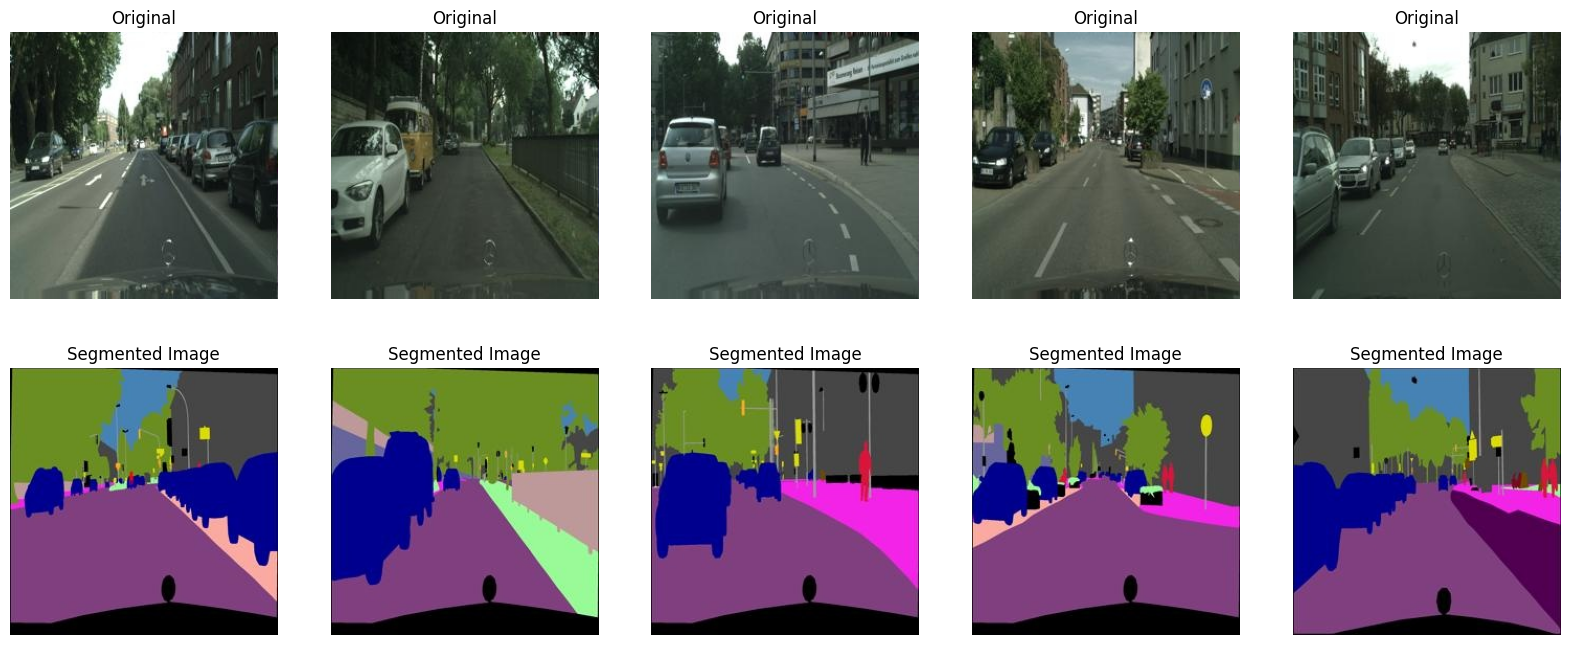

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a list of all image file paths in the train_dir
image_files = glob(os.path.join(train_dir, '*.jpg'))

# Select 5 random images
random_images = random.sample(image_files, 5)

# Display the selected images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    original_img, segmented_img = np.hsplit(img, 2)  # Split the image into two halves

    # Show the original image
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Show the segmented image
    axes[1, i].imshow(segmented_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Segmented Image')

plt.show()

Import libraries

Data Augmentation

In the case of this dataset and the problem that is being tackled it has been decided to not do data augmentation since it could interfere with the pixelwise or pixel level classification of each of the images with the intent of having a proper segmentation of the different classes.

# Preprocessing

- Resizing Images and Masks
Resizing the images and masks to a consistent size
- Color Conversion:
The color space of the images is converted from BGR (OpenCV default) to RGB using cv.cvtColor(image, cv.COLOR_BGR2RGB).
- Normalization:
The pixel values of the images and masks are normalized by dividing by 255.0.
- Data Splitting:
The code splits each image into two parts: the left half for the image and the right half for the mask.This is done because in this particular dataset the left side of the image corresponds to the original photo and the right portion of the image corresponds to the segmentation mask.

In [8]:
# Set the desired size of your images and masks
SIZE = 192

# Set the paths for saving images and masks
image_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/images"
mask_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/masks"

# Create the directories if they don't exist
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(mask_save_path, exist_ok=True)

# Initialize empty lists to store images and masks
images = []
masks = []

for i in tqdm(range(len(image_files))):
    path = image_files[i]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')

    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))

    # Convert the TensorFlow tensors to NumPy arrays
    img_np = img.numpy()
    mask_np = mask.numpy()

    # Append the resized image and mask to the lists
    images.append(img_np)
    masks.append(mask_np)

# Split the data into training and validation sets
X_train = images[:2900]
y_train = masks[:2900]

X_valid = images[2900:]
y_valid = masks[2900:]

100%|██████████| 2975/2975 [01:42<00:00, 28.95it/s]


# Working with the model


Define the model


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Conv2DTranspose

class ConvolutionBlock(tf.keras.Model):
    def __init__(self, out, padding=0):
        super().__init__()
        self.conv1 = Conv2D(out, (3, 3), padding='same')
        self.conv2 = Conv2D(out, (3, 3), padding='same')
        self.relu = ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class EncoderLayerBlock(tf.keras.Model):
    def __init__(self, out):
        super().__init__()
        self.conv = ConvolutionBlock(out)
        self.pool = MaxPooling2D((2, 2))

    def call(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return p

class DecoderLayerBlock(tf.keras.Model):
    def __init__(self, out):
        super().__init__()
        self.up = Conv2DTranspose(out, (2, 2), strides=(2, 2))
        self.conv = ConvolutionBlock(out)

    def call(self, inputs):
        x = self.up(inputs)
        x = self.conv(x)
        return x

class UnetAutoencoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = EncoderLayerBlock(64)
        self.d2 = EncoderLayerBlock(128)
        self.d3 = EncoderLayerBlock(256)
        self.d4 = EncoderLayerBlock(512)
        self.b = ConvolutionBlock(1024, 1)
        self.u1 = DecoderLayerBlock(512)
        self.u2 = DecoderLayerBlock(256)
        self.u3 = DecoderLayerBlock(128)
        self.u4 = DecoderLayerBlock(64)
        self.outputs = Conv2D(3, (1, 1), padding='same', activation='sigmoid')

    def call(self, inputs):
        p1 = self.d1(inputs)
        p2 = self.d2(p1)
        p3 = self.d3(p2)
        p4 = self.d4(p3)
        b = self.b(p4)
        u1 = self.u1(b)
        u2 = self.u2(u1)
        u3 = self.u3(u2)
        u4 = self.u4(u3)
        outputs = self.outputs(u4)
        return outputs

#  Callback
class ShowProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]

        plt.subplot(1,2,1)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [10]:
# Convert X_train, y_train, X_valid, and y_valid to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Ensure that X_train and y_train have the same number of samples
if len(X_train) != len(y_train):
    raise ValueError("X_train and y_train must have the same number of samples.")

# Ensure that X_valid and y_valid have the same number of samples
if len(X_valid) != len(y_valid):
    raise ValueError("X_valid and y_valid must have the same number of samples.")

Epoch 1/10
 6/91 [>.............................] - ETA: 54s - loss: 1.5649 - accuracy: 0.3305

1/1 [==============================] - 2s 2s/step


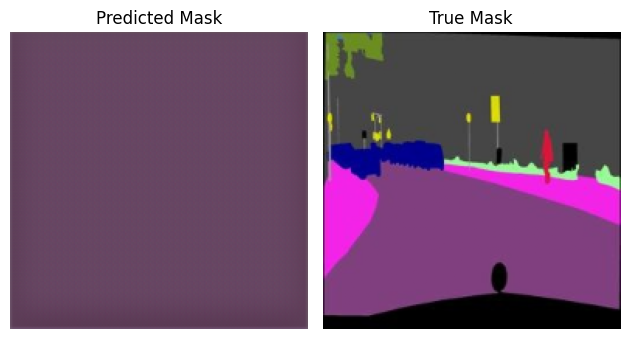

91/91 [==============================] - 113s 873ms/step - loss: 0.7189 - accuracy: 0.4528 - val_loss: 0.6384 - val_accuracy: 0.5762
Epoch 2/10
1/1 [==============================] - 0s 18ms/step


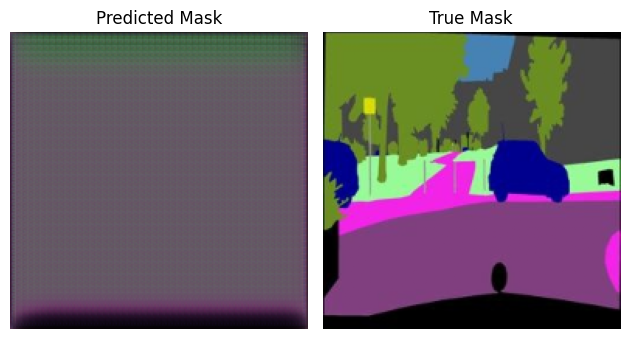

91/91 [==============================] - 57s 627ms/step - loss: 0.6334 - accuracy: 0.4839 - val_loss: 0.6172 - val_accuracy: 0.3853
Epoch 3/10
1/1 [==============================] - 0s 20ms/step


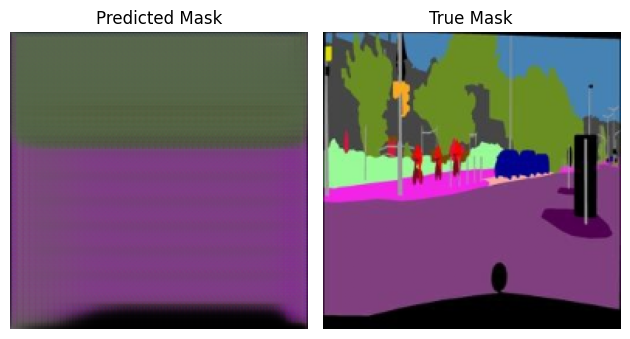

91/91 [==============================] - 57s 626ms/step - loss: 0.6220 - accuracy: 0.4134 - val_loss: 0.5979 - val_accuracy: 0.3117
Epoch 4/10
1/1 [==============================] - 0s 27ms/step


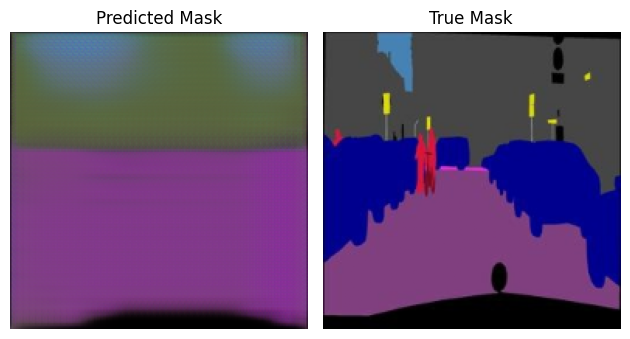

91/91 [==============================] - 57s 631ms/step - loss: 0.6075 - accuracy: 0.3596 - val_loss: 0.5982 - val_accuracy: 0.3528
Epoch 5/10
1/1 [==============================] - 0s 19ms/step


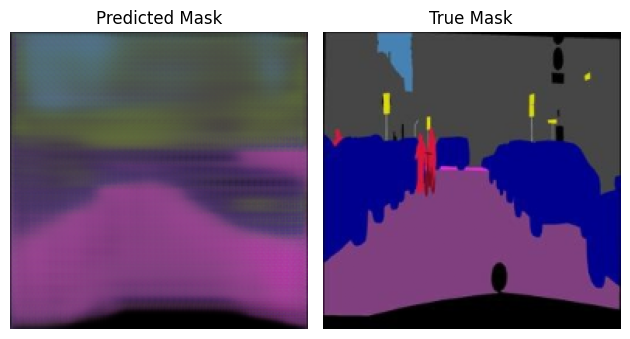

91/91 [==============================] - 57s 632ms/step - loss: 0.6009 - accuracy: 0.4496 - val_loss: 0.5850 - val_accuracy: 0.5967
Epoch 6/10
1/1 [==============================] - 0s 18ms/step


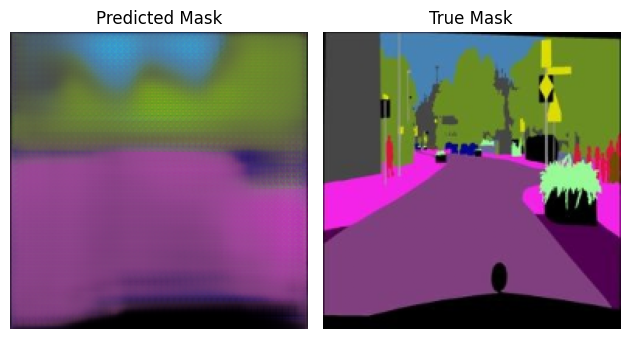

91/91 [==============================] - 57s 632ms/step - loss: 0.5960 - accuracy: 0.5294 - val_loss: 0.5857 - val_accuracy: 0.5766
Epoch 7/10
1/1 [==============================] - 0s 18ms/step


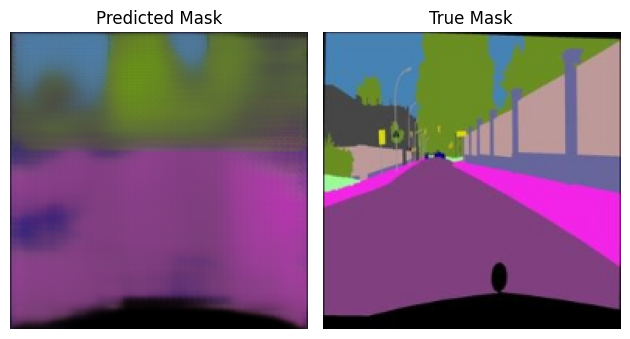

91/91 [==============================] - 57s 631ms/step - loss: 0.5924 - accuracy: 0.5741 - val_loss: 0.5779 - val_accuracy: 0.5740
Epoch 8/10
1/1 [==============================] - 0s 25ms/step


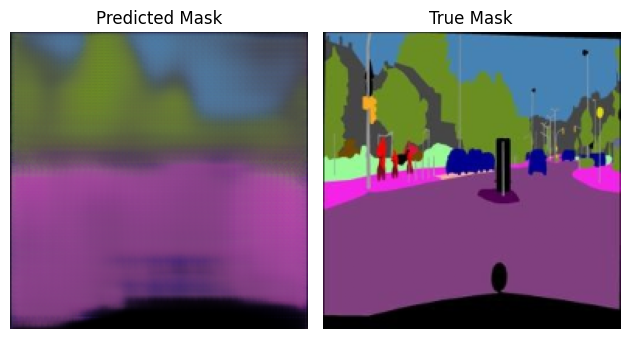

91/91 [==============================] - 58s 633ms/step - loss: 0.5908 - accuracy: 0.6081 - val_loss: 0.5806 - val_accuracy: 0.4882
Epoch 9/10
1/1 [==============================] - 0s 19ms/step


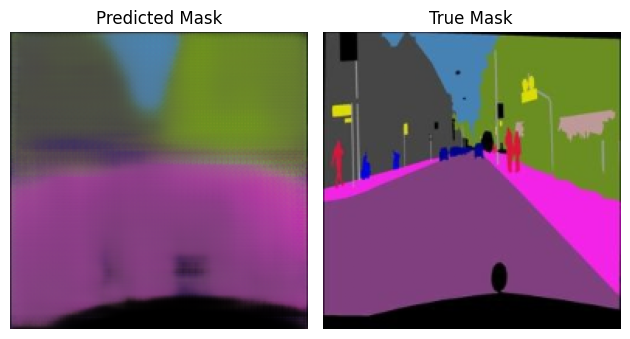

91/91 [==============================] - 57s 631ms/step - loss: 0.5854 - accuracy: 0.6272 - val_loss: 0.5697 - val_accuracy: 0.6296
Epoch 10/10
1/1 [==============================] - 0s 18ms/step


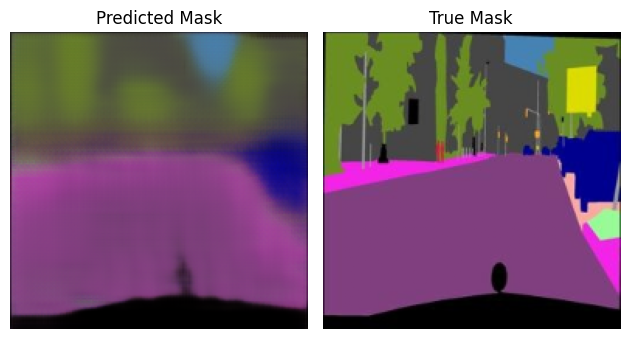

91/91 [==============================] - 57s 632ms/step - loss: 0.5818 - accuracy: 0.6418 - val_loss: 0.5689 - val_accuracy: 0.7107


In [11]:
# Compile the model
model = UnetAutoencoder()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the ShowProgress callback
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[ShowProgress()])

# Save the model

In [12]:
model.save('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model')
model.save_weights('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model.h5')

In [15]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_valid, y_valid)

# Print the evaluation results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


3/3 [==============================] - 1s 149ms/step - loss: 0.5689 - accuracy: 0.7107
Test Loss: 0.5688808560371399
Test Accuracy: 0.7107324004173279


In [ ]:
model.save('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model')
model.save_weights('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model.h5')

# Evaluating the model

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [21]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.718909,0.452789,0.638360,0.576243
1,0.633368,0.483934,0.617203,0.385346
2,0.621998,0.413374,0.597864,0.311743
3,0.607450,0.359617,0.598154,0.352846
4,0.600948,0.449607,0.585019,0.596704
5,0.596040,0.529425,0.585744,0.576619
6,0.592409,0.574100,0.577903,0.574022
7,0.590847,0.608052,0.580623,0.488176
8,0.585444,0.627223,0.569728,0.629551
9,0.581798,0.641829,0.568881,0.710732


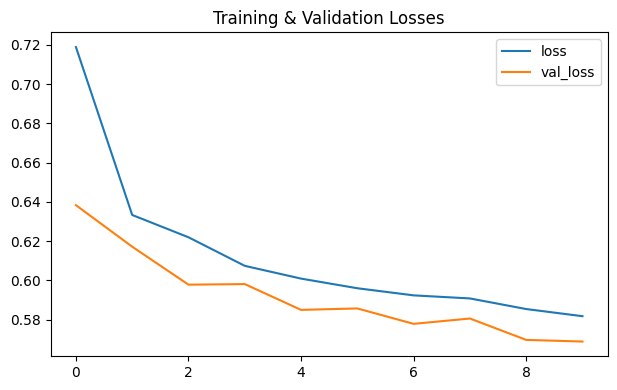

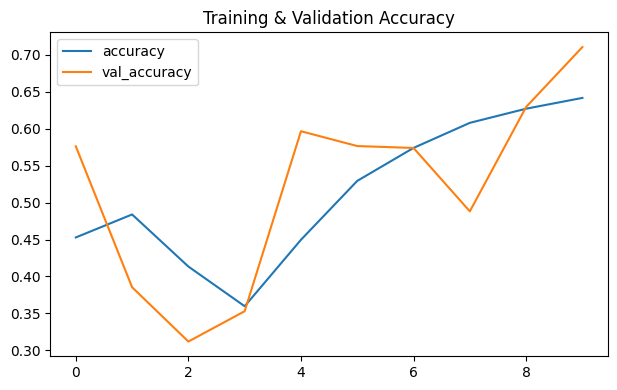

In [24]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.figure(figsize=(12, 4))  # Adjust the figure size
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()
    plt.tight_layout()  # Adjust the spacing between subplots

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)


# Utilizing Model

First we should load the model

In [ ]:
# new_model = keras.models.load_model('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data')

# Improving the base model

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Conv2DTranspose, Dropout, concatenate

class ConvolutionBlock(tf.keras.Model):
    def __init__(self, out, rate, padding=0):
        super().__init__()
        self.conv1 = Conv2D(out, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.conv2 = Conv2D(out, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.drop(x)
        x = self.conv2(x)
        return x

class EncoderLayerBlock(tf.keras.Model):
    def __init__(self, out, rate, pooling=True):
        super().__init__()
        self.conv = ConvolutionBlock(out, rate)
        self.pool = MaxPooling2D((2, 2))
        self.pooling = pooling

    def call(self, inputs):
        x = self.conv(inputs)
        if self.pooling:
            p = self.pool(x)
            return p, x
        else:
            return x

class DecoderLayerBlock(tf.keras.Model):
    def __init__(self, out, rate, padding='same'):
        super().__init__()
        self.up = Conv2DTranspose(out, (2, 2), strides=(2, 2), padding=padding)
        self.next = ConvolutionBlock(out, rate)

    def call(self, inputs):
        x, skip_x = inputs
        x = self.up(x)
        x = concatenate([x, skip_x])
        x = self.next(x)
        return x

class UnetAutoencoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = EncoderLayerBlock(16, 0.1)
        self.d2 = EncoderLayerBlock(32, 0.1)
        self.d3 = EncoderLayerBlock(64, 0.2)
        self.d4 = EncoderLayerBlock(128, 0.2)
        self.b = EncoderLayerBlock(256, 0.3, pooling=False)
        self.u1 = DecoderLayerBlock(128, 0.2)
        self.u2 = DecoderLayerBlock(64, 0.2)
        self.u3 = DecoderLayerBlock(32, 0.2)
        self.u4 = DecoderLayerBlock(16, 0.2)
        self.outputs = Conv2D(3, (1, 1), padding='same', activation='sigmoid')

    def call(self, inputs):
        p1, c1 = self.d1(inputs)
        p2, c2 = self.d2(p1)
        p3, c3 = self.d3(p2)
        p4, c4 = self.d4(p3)
        b = self.b(p4)
        u1 = self.u1([b, c4])
        u2 = self.u2([u1, c3])
        u3 = self.u3([u2, c2])
        u4 = self.u4([u3, c1])
        outputs = self.outputs(u4)
        return outputs

#  Callback
class ShowProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]

        plt.subplot(1,2,1)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
# Compile the model
model = UnetAutoencoder()
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks
callbacks =[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

# Train the model with the ShowProgress callback
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid), callbacks=[ShowProgress()])

# Improvement with transfer learning